# Aerial-Cactus-Identification
Determine whether an image contains a columnar cactus

### Load and preprocessing data

In [103]:
import pandas as pd
import os
import random
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.python.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger
from tensorflow.keras import optimizers, models
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import applications
from tensorflow.keras import backend as K
import math

In [2]:
ls aerial-cactus-identification_data/

sample_submission.csv* train/
test/                  train.csv*


In [3]:
df = pd.read_csv("./aerial-cactus-identification_data/train.csv")
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
# df['id'] = df['id'].apply(lambda x:os.path.join('./aerial-cactus-identification_data/train', x))
# df.head()

In [5]:
labels = {0:"no_cactus", 1:"has_cactus"}

for idx, i in enumerate(df["has_cactus"]):
    df.loc[idx, "has_cactus"] = labels[i]
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,has_cactus
1,000c8a36845c0208e833c79c1bffedd1.jpg,has_cactus
2,000d1e9a533f62e55c289303b072733d.jpg,has_cactus
3,0011485b40695e9138e92d0b3fb55128.jpg,has_cactus
4,0014d7a11e90b62848904c1418fc8cf2.jpg,has_cactus


In [46]:
df = shuffle(df, random_state=100)
df.reset_index(drop=True, inplace=True)
df.head()

,id,has_cactus
0,ca248b5dff843e0561d6d16a994b21bf.jpg,has_cactus
1,902476d3f57a4c672d8e98c70bb2b9ae.jpg,has_cactus
2,206c1e80459fbdfdd71843b391c8f7fc.jpg,has_cactus
3,f624bf0ca1eb58a9d927642fae913838.jpg,has_cactus
4,04d3cd55c16808a0e078b05c5dc17628.jpg,has_cactus


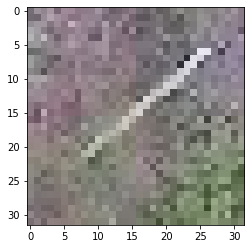

In [47]:
# Load random image

img_list = list(df['id'])
random_img = random.choice(img_list)
img = load_img(os.path.join("./aerial-cactus-identification_data/train", random_img))
plt.imshow(img)

In [48]:
df_val = df.iloc[:int(0.1*len(df))]
df_val.reset_index(drop=True, inplace=True)
df_val.head()

,id,has_cactus
0,ca248b5dff843e0561d6d16a994b21bf.jpg,has_cactus
1,902476d3f57a4c672d8e98c70bb2b9ae.jpg,has_cactus
2,206c1e80459fbdfdd71843b391c8f7fc.jpg,has_cactus
3,f624bf0ca1eb58a9d927642fae913838.jpg,has_cactus
4,04d3cd55c16808a0e078b05c5dc17628.jpg,has_cactus


In [49]:
df_train = df.iloc[int(0.1*len(df)):]
df_train.reset_index(drop=True, inplace=True)
df_train.head()

,id,has_cactus
0,979bd09a25723eb2dc083ceed923a300.jpg,has_cactus
1,e5c540552e0f0fb7132b822d42e2d779.jpg,has_cactus
2,584a06ac05b37e3b6cdf2ccc3ced6682.jpg,has_cactus
3,927276f8a53af33aa42509ed7ce42543.jpg,has_cactus
4,49a2ae4f4030a517e759660789ab3cc0.jpg,has_cactus


In [53]:
WIDTH=32
HEIGHT=32
BATCH_SIZE=4

train_dir = "./aerial-cactus-identification_data/train/"

In [56]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
# datagen=ImageDataGenerator(rescale=1./255)

train_flow=train_generator.flow_from_dataframe(
dataframe=df_train,
directory=train_dir,
x_col="id",
y_col="has_cactus",
# subset="training",
batch_size=BATCH_SIZE,
# seed=None,
# shuffle=None,
class_mode="binary",
target_size=(HEIGHT,WIDTH))

Found 15750 validated image filenames belonging to 2 classes.


In [57]:
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

val_flow=val_generator.flow_from_dataframe(
dataframe=df_val,
directory=train_dir,
x_col="id",
y_col="has_cactus",
# subset="training",
batch_size=BATCH_SIZE,
# seed=None,
# shuffle=None,
class_mode="binary",
target_size=(HEIGHT,WIDTH))

Found 1750 validated image filenames belonging to 2 classes.


In [63]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(WIDTH, HEIGHT,3), pooling=max)

In [78]:
x = base_model.output

x = GlobalAveragePooling2D()(x)
# and a dense layer
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=0.0001), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='binary_crossentropy')
model.summary()

W0914 21:20:28.845304 140736375567296 deprecation.py:323] From /Users/aravindagayan/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Total params: 20,290,113
Trainable params: 1,968,129
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [79]:
saved_model_path="aerial_cactus_freezed_v1.hdf5"

checkpoint = ModelCheckpoint(saved_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
tb = TensorBoard(log_dir='./logs', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger('./logs/aerial_cactus_log.csv', append=True)

history = model.fit_generator(train_flow, 
                              epochs=1, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

3937/3938 [============================>.] - ETA: 0s - loss: 0.3281 - acc: 0.8598 - top_k_categorical_accuracy: 1.0000
Epoch 00001: loss improved from inf to 0.32813, saving model to aerial_cactus_freezed_v1.hdf5
3938/3938 [==============================] - 936s 238ms/step - loss: 0.3282 - acc: 0.8597 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3361 - val_acc: 0.8480 - val_top_k_categorical_accuracy: 1.0000


In [81]:
saved_model_path="aerial_cactus_freezed_v1.hdf5"

model = load_model(saved_model_path)

for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=optimizers.Adam(lr=0.00001), metrics=['accuracy', 'top_k_categorical_accuracy'], loss='binary_crossentropy')
model.summary()

W0914 21:38:09.178425 140736375567296 deprecation.py:506] From /Users/aravindagayan/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0914 21:38:09.179397 140736375567296 deprecation.py:506] From /Users/aravindagayan/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0914 21:38:09.181032 140736375567296 deprecation.py:506] From /Users/aravindagayan/anaconda3/envs/keras/lib/python3.7/site-packages/tensorflow/python/ops/init_

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 38, 38, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Total params: 20,290,113
Trainable params: 1,968,129
Non-trainable params: 18,321,984
__________________________________________________________________________________________________


In [82]:
saved_model_path="aerial_cactus_unfreezed_v2.hdf5"

checkpoint = ModelCheckpoint(saved_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
tb = TensorBoard(log_dir='./logs', batch_size=val_flow.batch_size, write_graph=True, update_freq='batch')
early = EarlyStopping(monitor="loss", mode="min", patience=5)
csv_logger = CSVLogger('./logs/aerial_cactus_log.csv', append=True)

train_flow.reset()
val_flow.reset()

history = model.fit_generator(train_flow, 
                              epochs=1, 
                              verbose=1,
                              validation_data=val_flow,
                              validation_steps=math.ceil(val_flow.samples/val_flow.batch_size),
                              steps_per_epoch=math.ceil(train_flow.samples/train_flow.batch_size),
                              callbacks=[checkpoint, early, tb, csv_logger])

3937/3938 [============================>.] - ETA: 0s - loss: 0.2799 - acc: 0.8807 - top_k_categorical_accuracy: 1.0000
Epoch 00001: loss improved from inf to 0.27997, saving model to aerial_cactus_unfreezed_v2.hdf5
3938/3938 [==============================] - 1056s 268ms/step - loss: 0.2800 - acc: 0.8806 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3434 - val_acc: 0.8503 - val_top_k_categorical_accuracy: 1.0000


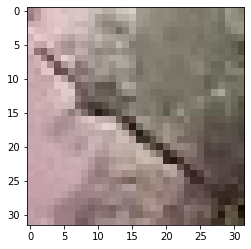

In [115]:
# Testing
import glob

test_dir = "./aerial-cactus-identification_data/test/*"

file_list = glob.glob(test_dir)
img_path = random.choice(file_list)

img = load_img(img_path, target_size=(32, 32))
plt.imshow(img)

In [120]:
test_df = pd.DataFrame(columns=["id","has_cactus"])

In [130]:
for idx,i in enumerate(file_list):
    test_df.loc[idx,"id"] = i.split("/")[-1]
    
    img = load_img(i, target_size=(32, 32))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    
    test_df.loc[idx,"has_cactus"] = preds[0][0]

In [132]:
test_df.to_csv("test.csv")

In [144]:
df_new = test_df.copy()
df_new

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,6.08922e-05
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.03173e-05
2,001ee6d8564003107853118ab87df407.jpg,0.538337
3,002e175c3c1e060769475f52182583d0.jpg,0.930744
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,3.34535e-07
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,0.00814442
3996,ffae37344310a1549162493237d25d3f.jpg,0.000119361
3997,ffbd469c56873d064326204aac546e0d.jpg,0.000121204
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,0.000987204


In [145]:
# test_df.has_cactus.round(1) 
df_new['has_cactus'] = df_new['has_cactus'].apply(lambda x: round(x, 1))

In [151]:
df_new.to_csv("Aerial-Cactus-Identification_submission.csv",index=False)

In [152]:
df_new.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.0
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.0
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.9
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.0
